<h1 align="center">Volume 4: HIV</h1>

    Samuel Goldrup
    Section 2
    2 March 2023

In [1]:
import numpy as np
import matplotlib
matplotlib.use('nbAgg')
from matplotlib import pyplot as plt

In [2]:
#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

# Problem 1

Create a function that defines the state equations and returns both equations in
a single array. The function should be able to be passed into the RK4 solver.

In [3]:
# define constants

a_1, a_2 = 0, 0
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2., 1.5
mu = 0.002
k = 0.000025    # The paper uses .00025, but it's hard to determine which solution actually makes sense.
g = 30.
c = 0.007
B_1, B_2 = 14, 1
A_1, A_2 = 250000, 75
T0, V0 = 400, 3
t_f = 50
n = 2000

# initialize global variables, state, costate, and u.
state = np.zeros((n,2))
state0 = np.array([T0, V0])

costate = np.zeros((n,2))
costate0 = np.zeros(2)

u=np.zeros((n,2))
u[:,0] = .02
u[:,1] = .9

# define state equations
def state_equations(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the T cell concentration and the Virus concentration at time t
    i : int
        index for the global variable u.
    
    Returns
    --------------
    y_dot : ndarray (2,)
            the derivative of the T cell concentration and the virus
            concentration at time t
    '''
    #return the rhs of the differential equations
    dT = s_1 - (s_2*y[1]/(B_1+y[1])) - mu*y[0] - k*y[1]*y[0] + u[i,0]*y[0] #u1
    dV = (g*y[1]/(B_2+y[1]))*(1-u[i,1]) - c*y[1]*y[0] #u2
    return np.array([dT,dV])

# Problem 2

Create a function that defines the costate equations and returns both equations
in a single array. The function should be able to be passed into the RK4 solver. Use the global
variables as defined in Problem 1.

In [4]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda_hat values at time (tf-t)
    i : int
    index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time (tf-t).
    '''
    lm1, lm2 = y
    t_c,v_c,u1,u2 = state[n-1-i,0], state[n-1-i,1], u[n-1-i,0], u[n-1-i,1]
    
    #return rhs of the DE for lagrange multipliers of Hamiltonian
    dl1 = lm1*(-mu-k*v_c+u1)-c*lm2*v_c+1
    dl2 = -lm1*((s_2*B_1/((B_1+v_c))**2) + k*t_c) + lm2*(((g*B_2*(1-u2))/(B_2+v_c)**2)-c*t_c)
    return np.array([dl1,dl2])
    

# Problem 3

Create and run a numerical solver for the HIV two drug model. Plot the solution.

In [5]:
epsilon = 0.001
test = epsilon + 1
t0 = 0

#implementing the closed form optimization solution
u1_star = lambda lm1,T: np.min([np.max([a_1,(1/(2*A_1))*lm1*T]),b_1])
u2_star = lambda lm2,V: np.min([np.max([a_2,(-lm2/(2*A_2))*(g*V/(B_2+V))]),b_2])

while(test > epsilon):
    oldu = u.copy();
    
    #solve the state equations with forward iteration
    #state = RK4(...)
    state = RK4(state_equations,state0,t0,t_f,n)
    
    
    #solve the costate equations with backwards iteration
    #costate = RK4(...)[::-1]
    costate = RK4(lambda_hat,costate0,t0,t_f,n)[::-1]
    
    #solve for u1 and u2
    u1 = [u1_star(lm1,T) for lm1,T in zip(costate[:,0],state[:,0])]
    u2 = [u2_star(lm2,V) for lm2,V in zip(costate[:,1],state[:,1])]
    
    #for zip in state[:,0],costate[:,0] something like that
    #update control
    u[:,0] = 0.5*(u1 + oldu[:,0])
    u[:,1] = 0.5*(u2 + oldu[:,1])
    
    #print(u)
    
    #test for convergence
    test = abs(oldu - u).sum()

<IPython.core.display.Javascript object>


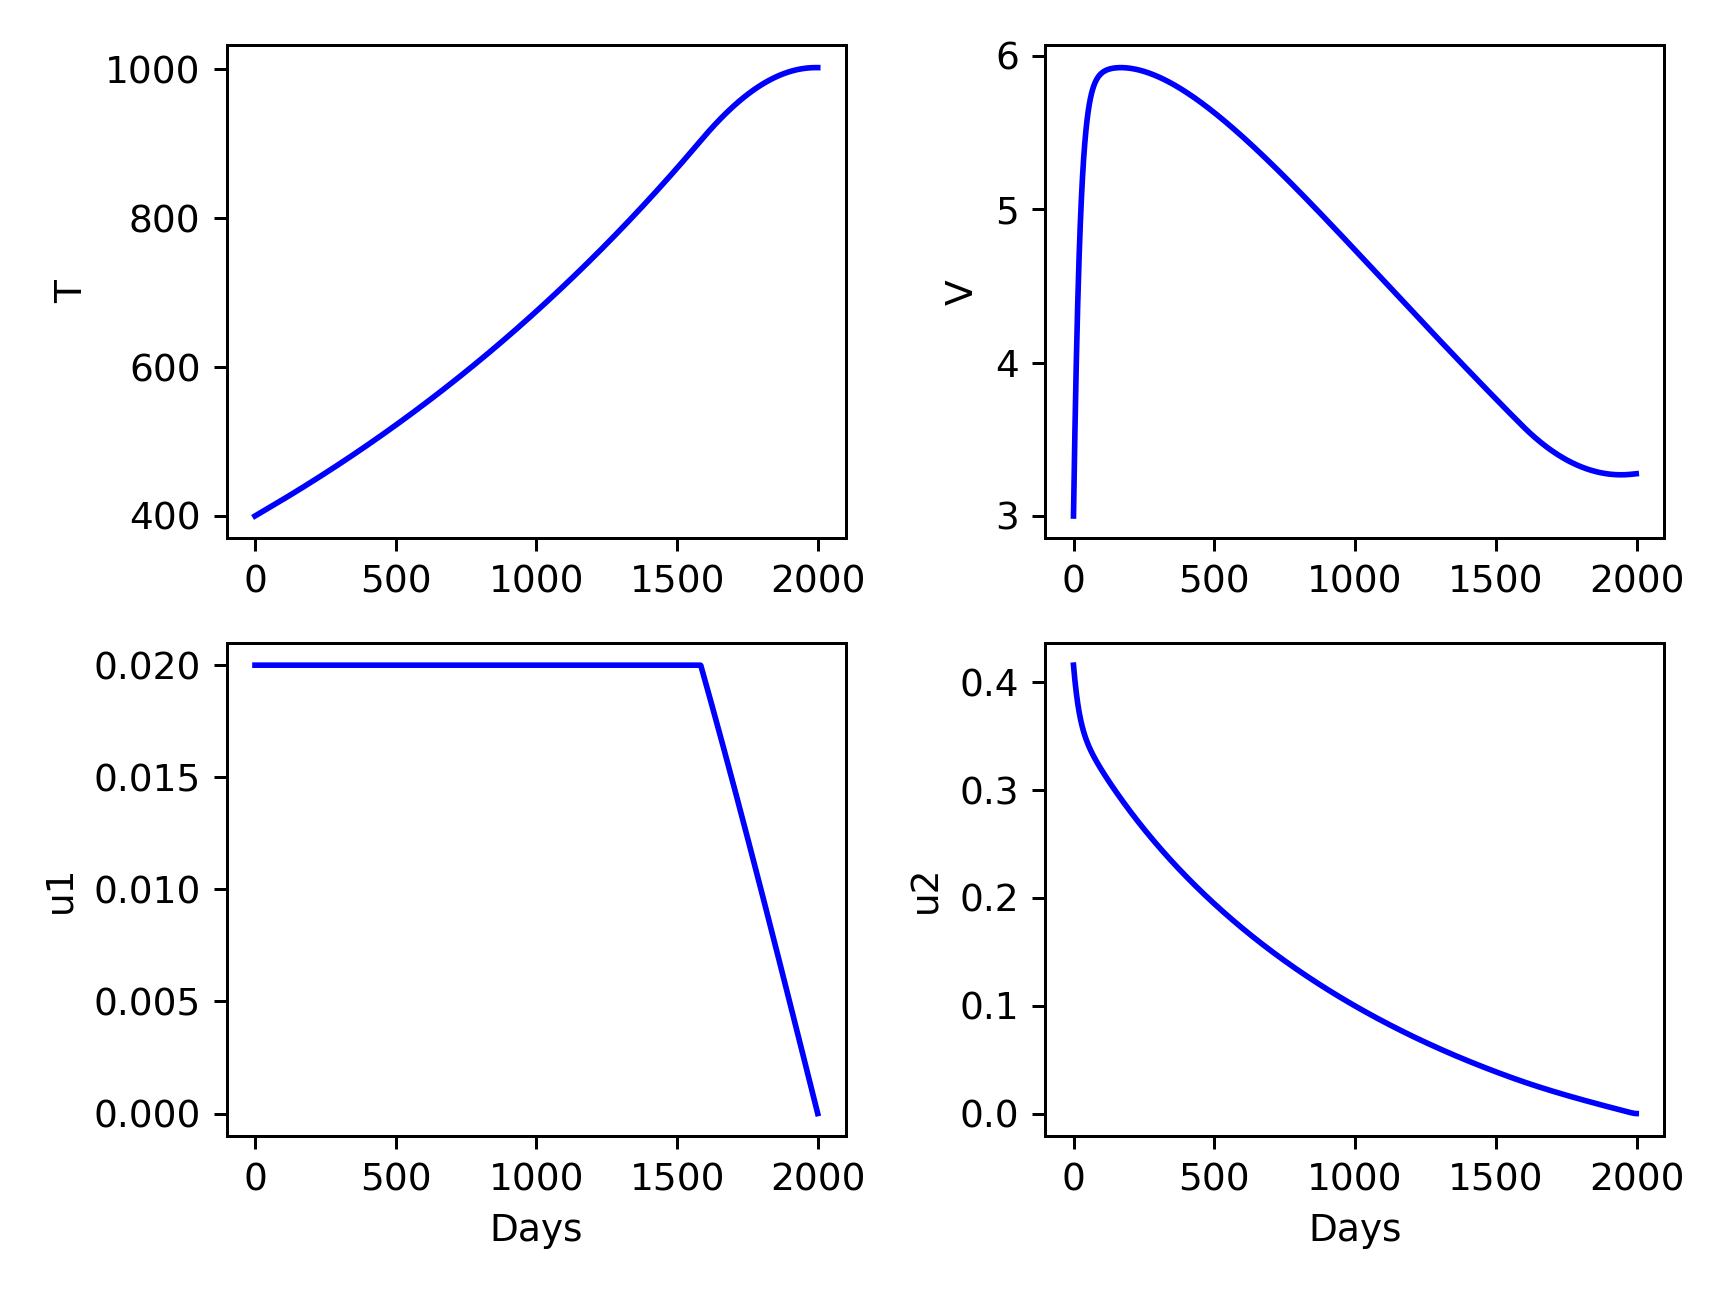

In [6]:
plt.subplots(2,2)
plt.subplot(2,2,1).plot(state[:,0],color="blue")
plt.ylabel("T")
plt.subplot(2,2,2).plot(state[:,1],color="blue")
plt.ylabel("V")
plt.subplot(2,2,3).plot(u[:,0],color="blue")
plt.xlabel("Days")
plt.ylabel("u1")
plt.subplot(2,2,4).plot(u[:,1],color="blue")
plt.ylabel("u2")
plt.xlabel("Days")
plt.tight_layout()
plt.show()